In [33]:
import tensorflow as tf
from tensorflow.keras import layers
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-03-02 09:42:00--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.2’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-03-02 09:42:00 (69.3 MB/s) - ‘helper_functions.py.2’ saved [10246/10246]



# MNIST

## Explore data

In [34]:
import tensorflow as tf

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

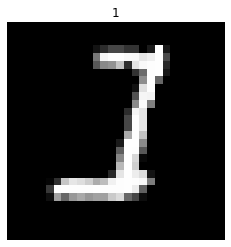

In [35]:
import matplotlib.pyplot as plt
import random
n = random.randint(0,len(x_train))
plt.imshow(x_train[n], cmap='gray')
plt.title(y_train[n])
plt.axis('off');

In [36]:
x_train.shape, tf.reduce_max(x_train).numpy(), tf.reduce_min(x_train).numpy()

((60000, 28, 28), 255, 0)

In [37]:
y_train.shape, tf.reduce_max(y_train).numpy(), tf.reduce_min(y_train).numpy() # integer

((60000,), 9, 0)

## Conv2D

In [38]:
import numpy as np
import tensorflow as tf
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print('y_train shape:', y_train.shape)

x_train shape: (60000, 28, 28, 1)
y_train shape: (60000,)


In [39]:
train_data = tf.data.Dataset.from_tensor_slices(x_train)
train_label = tf.data.Dataset.from_tensor_slices(y_train)
train = tf.data.Dataset.zip((train_data, train_label))
train = train.batch(32).prefetch(tf.data.AUTOTUNE) # batch & prefetch

test_data = tf.data.Dataset.from_tensor_slices(x_test)
test_label = tf.data.Dataset.from_tensor_slices(y_test)
test = tf.data.Dataset.zip((test_data, test_label))
test = test.batch(32).prefetch(tf.data.AUTOTUNE)

train, test

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.uint8, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.uint8, name=None))>)

In [40]:
# Same as above
# train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# train = train.batch(32).prefetch(tf.data.AUTOTUNE)
# test = tf.data.Dataset.from_tensor_slices((x_test, y_test))
# test = test.batch(32).prefetch(tf.data.AUTOTUNE)
# train, test

In [41]:
from tensorflow.keras import layers

input = layers.Input(shape=(28,28,1), name='Input')
x = layers.BatchNormalization()(input)
x = layers.Conv2D(filters=32,
                  kernel_size=3,
                  activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(32,3, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPool2D(pool_size=2)(x)
x = layers.Conv2D(64,3, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64,3, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)
x = layers.MaxPool2D(pool_size=2)(x)
x = layers.Flatten()(x)
output = layers.Dense(10, activation='softmax')(x)
model_0 = tf.keras.Model(input, output, name = 'Conv2D_model')

model_0.compile(loss = 'sparse_categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

history_model_0 = model_0.fit(train,
                              epochs=5,
                              validation_data = test,
                              callbacks = [tf.keras.callbacks.ModelCheckpoint('model_checkpoint/model_0',
                                                      monitor = 'val_accuracy',
                                                      save_best_only=True, # save the best model which has the highest val_acc
                                                      save_weights_only=True)])

Epoch 1/5
1875/1875 [==============================] - 14s 7ms/step - loss: 0.1133 - accuracy: 0.9668 - val_loss: 0.0814 - val_accuracy: 0.9744
Epoch 2/5
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0501 - accuracy: 0.9859 - val_loss: 0.0462 - val_accuracy: 0.9848
Epoch 3/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0384 - accuracy: 0.9889 - val_loss: 0.0389 - val_accuracy: 0.9892
Epoch 4/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0316 - accuracy: 0.9907 - val_loss: 0.0357 - val_accuracy: 0.9899
Epoch 5/5
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0246 - accuracy: 0.9927 - val_loss: 0.0396 - val_accuracy: 0.9885


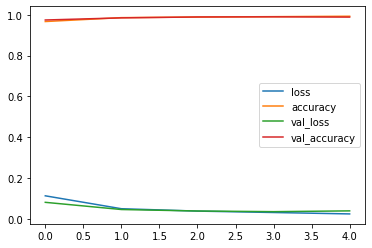

In [42]:
import pandas as pd
pd.DataFrame(history_model_0.history).plot()

In [43]:
best_model_0 = tf.keras.models.clone_model(model_0) # clone model_0 architechture
best_model_0.load_weights('model_checkpoint/model_0')

best_model_0.compile(loss = 'sparse_categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics=['accuracy']) # must compile after load_weights

best_model_0.evaluate(test)

313/313 [==============================] - 1s 3ms/step - loss: 0.0357 - accuracy: 0.9899


[0.03568584471940994, 0.9898999929428101]

### Make Predictions

In [44]:
pred_prob = best_model_0.predict(x_test)
pred = tf.argmax(pred_prob, axis=1)
pred[:5].numpy(), y_test[:5],  pred_prob.shape

(array([7, 2, 1, 0, 4]), array([7, 2, 1, 0, 4], dtype=uint8), (10000, 10))

In [45]:
from helper_functions import calculate_results
calculate_results(y_true = y_test,
                  y_pred = pred)

{'accuracy': 98.99,
 'f1': 0.9898991851118278,
 'precision': 0.9899810897258154,
 'recall': 0.9899}

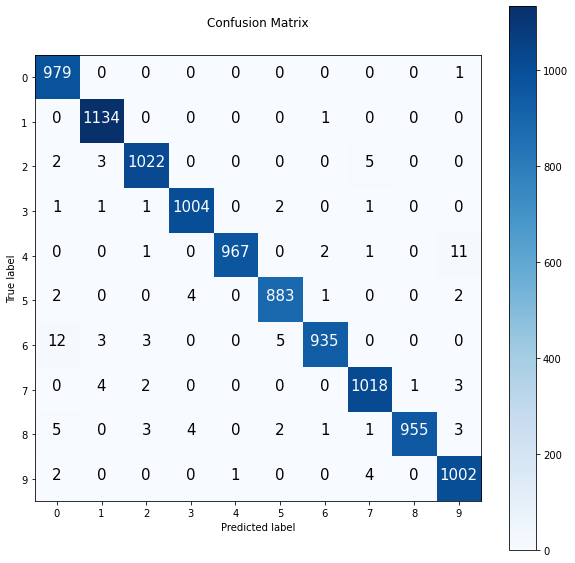

In [46]:
from helper_functions import make_confusion_matrix
make_confusion_matrix(y_true = y_test,
                      y_pred = pred)

## Dense

In [47]:
import tensorflow as tf
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [48]:
train_data = tf.data.Dataset.from_tensor_slices(x_train)
train_label = tf.data.Dataset.from_tensor_slices(y_train)
train = tf.data.Dataset.zip((train_data, train_label))
train = train.batch(32).prefetch(tf.data.AUTOTUNE)

test_data = tf.data.Dataset.from_tensor_slices(x_test)
test_label = tf.data.Dataset.from_tensor_slices(y_test)
test = tf.data.Dataset.zip((test_data, test_label))
test = test.batch(32).prefetch(tf.data.AUTOTUNE)

train, test

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 28, 28), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.uint8, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 28, 28), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.uint8, name=None))>)

In [49]:
from tensorflow.keras import layers
input = layers.Input(shape=(28,28))
x = layers.Flatten()(input)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(10, activation='softmax')(x)
model_1 = tf.keras.Model(input, output)

model_0.compile(loss = 'sparse_categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

history_model_1 = model_0.fit(train,
                              epochs=5,
                              validation_data = test,
                              callbacks = [tf.keras.callbacks.ModelCheckpoint('model_checkpoint/model_1',
                                                      monitor = 'val_accuracy',
                                                      save_best_only=True, # save the best model which has the highest val_acc
                                                      save_weights_only=False
                              )])

Epoch 1/5
1873/1875 [============================>.] - ETA: 0s - loss: 0.0205 - accuracy: 0.9939WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


INFO:tensorflow:Assets written to: model_checkpoint/model_1/assets


INFO:tensorflow:Assets written to: model_checkpoint/model_1/assets


1875/1875 [==============================] - 12s 6ms/step - loss: 0.0205 - accuracy: 0.9939 - val_loss: 0.0472 - val_accuracy: 0.9889
Epoch 2/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0175 - accuracy: 0.9944 - val_loss: 0.0509 - val_accuracy: 0.9879
Epoch 3/5
1874/1875 [============================>.] - ETA: 0s - loss: 0.0149 - accuracy: 0.9955

INFO:tensorflow:Assets written to: model_checkpoint/model_1/assets


INFO:tensorflow:Assets written to: model_checkpoint/model_1/assets


1875/1875 [==============================] - 10s 6ms/step - loss: 0.0149 - accuracy: 0.9955 - val_loss: 0.0418 - val_accuracy: 0.9900
Epoch 4/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0117 - accuracy: 0.9961 - val_loss: 0.0502 - val_accuracy: 0.9884
Epoch 5/5
1866/1875 [============================>.] - ETA: 0s - loss: 0.0116 - accuracy: 0.9960

INFO:tensorflow:Assets written to: model_checkpoint/model_1/assets


INFO:tensorflow:Assets written to: model_checkpoint/model_1/assets


1875/1875 [==============================] - 10s 6ms/step - loss: 0.0119 - accuracy: 0.9960 - val_loss: 0.0384 - val_accuracy: 0.9912


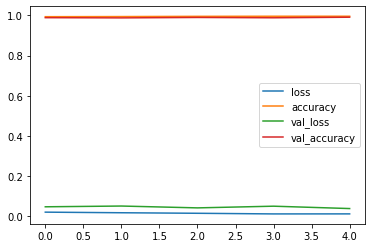

In [50]:
import pandas as pd
pd.DataFrame(history_model_1.history).plot()

In [51]:
best_model_1 = tf.keras.models.load_model('model_checkpoint/model_1')
best_model_1.evaluate(test)

313/313 [==============================] - 1s 3ms/step - loss: 0.0384 - accuracy: 0.9912


[0.038415003567934036, 0.9911999702453613]

### Make Predictions

In [52]:
pred_prob = best_model_1.predict(x_test)
pred = tf.argmax(pred_prob, axis=1)
pred[:5].numpy(), y_test[:5]

(array([7, 2, 1, 0, 4]), array([7, 2, 1, 0, 4], dtype=uint8))

In [53]:
calculate_results(y_true = y_test,
                  y_pred = pred)

{'accuracy': 99.11999999999999,
 'f1': 0.9911991400322533,
 'precision': 0.9912355298427592,
 'recall': 0.9912}

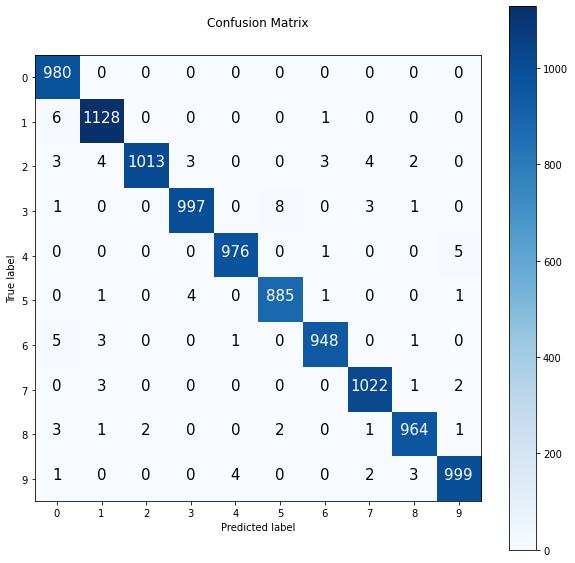

In [54]:
make_confusion_matrix(y_true = y_test,
                      y_pred = pred)